In [179]:
import warnings
import pandas as pd 
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
My_vectorizer = TfidfVectorizer ()
warnings.filterwarnings("ignore")
from sklearn.decomposition import TruncatedSVD
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import os
import nltk
import emojis
import re
from sklearn.pipeline import Pipeline
import string
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from gensim.models.coherencemodel import CoherenceModel
from IPython import display
import plotly.graph_objs as go
from plotly.offline import iplot
import emoji
from collections import Counter
import pip
!pip install textblob      #for installation
import textblob            #to import
from textblob import TextBlob
import matplotlib.pyplot as plt
!pip install plotly==5.13.0
from wordcloud import WordCloud, STOPWORDS

df=pd.read_csv("A2_Data.csv")

[nltk_data] Downloading package punkt to /Users/sselemahs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sselemahs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
df2.head

<bound method NDFrame.head of         Unnamed: 0                                               text  \
1                1  Heads up! I'll be going live this Thursday at ...   
4                4   FutureSELF Collection ! Search FutureSELF to ...   
15              15      @CNBC @ETFEdgeCNBC Just buy #Bitcoin and hodl   
16              16  We should never forget and let go this piece o...   
18              18  #BTC Facing first major res on dailyTaking out...   
...            ...                                                ...   
197738      197738      #Bitcoin meet-up in San Jose Costa Rica 🇨🇷\n    
197741      197741  Short Term #Bitcoin Hodl’ers  holds the most a...   
197746      197746  #DeFi #TeleFy #DEX #cryptocurrency #Ethereum #...   
197747      197747  If you know what you want if your goal is clea...   
197748      197748  @TelefyConnect #DeFi #TeleFy #DEX #cryptocurre...   

       RiseFall                                       Stemmed_text  \
1         Equal  head !

### Text preparation

In [181]:
df1= df.reset_index(drop=True)
df1 = df.loc[(df['user_followers'] > df['user_followers'].median())  &(df['user_friends']>df['user_friends'].median()) &(df['user_favourites']>df['user_favourites'].median())]

df2 = df1[["Unnamed: 0","text","RiseFall"]]

#delete emotion and tone indications between brackets
df2['text']=df2['text'].str.replace(r"\(.*\)","")
#Replace one character for another
df2['text'] = df2['text'].str.replace('.', '')
df2['text'] = df2['text'].str.replace(',', '')
#Strip unnecessary spaces
df2['text']= df2['text'].str.strip()
#Remove URL
df2['text'] = df2['text'].str.replace('http\S+|www.\S+', '', case=False)

#tokenising
df3 = df2['text'].apply(word_tokenize)
#case folding
df4 = df3.apply(lambda x: [word.lower() for word in x])

#Stopwords Removal
My_stop_words = stopwords.words("English")
My_stop_words = My_stop_words + ['bitcoin','eth','btc','crypto','cryptocurrency','blockchain','project','orijin','ido','binance','bnb','bsc','amp','tco','ethereum','market','price','buy','sell','polygon','defi','airdrop','bullish','cryptocurrencies','safemoon','safemoonomics','sfm']
df5 = df4.apply(lambda x: [word for word in x if word not in My_stop_words])  

#Stemming
My_stemmer = SnowballStemmer("english")
df6 = df5.apply(lambda x:[My_stemmer.stem(word) for word in x])
 
#Lemmatizer
wn = nltk.WordNetLemmatizer()
def lemmatizing(df3):
    text = [wn.lemmatize(word) for word in df3]
    return text
df_lemmatized = df5.apply(lambda x:lemmatizing (x))

#Enriching data
df7 = df6.apply(lambda x:" ".join(x))
df_enriched=df2
df_enriched["Stemmed_text"]=df7

df8 = df_lemmatized.apply(lambda x:" ".join(x))
df_enriched=df2
df_enriched["Lematized_text"]=df8

In [ ]:
df2.head

<bound method NDFrame.head of         Unnamed: 0                                               text  \
1                1  Heads up! I'll be going live this Thursday at ...   
4                4   FutureSELF Collection ! Search FutureSELF to ...   
15              15      @CNBC @ETFEdgeCNBC Just buy #Bitcoin and hodl   
16              16  We should never forget and let go this piece o...   
18              18  #BTC Facing first major res on dailyTaking out...   
...            ...                                                ...   
197738      197738      #Bitcoin meet-up in San Jose Costa Rica 🇨🇷\n    
197741      197741  Short Term #Bitcoin Hodl’ers  holds the most a...   
197746      197746  #DeFi #TeleFy #DEX #cryptocurrency #Ethereum #...   
197747      197747  If you know what you want if your goal is clea...   
197748      197748  @TelefyConnect #DeFi #TeleFy #DEX #cryptocurre...   

       RiseFall                                       Stemmed_text  \
1         Equal  head !

- The process of text preparation is data cleaning, tokenising, case folding, stop words removal, lemmatizing, and enriching the data.
- To exclude the invalid accounts, I only select the users whose friends, followers, favourites are above median into the analysis part. 
- Instead of getting rid of all the punctuations, I chose to only move the ',' and '.'. And I tried to delete all the unnecessary spaces and the content within the brackets, which could be helpful while implementing the word cloud later.
- I deleted all the URL in the text as well because it appears in wordcloud,which means it's commonly used.
- I also added some stop words regarding to the crypto currency.

### Feature generation 1 - date information

In [182]:
#group by the date information
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df_date=df[['date']]
df.groupby('RiseFall')['month'].mean()

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
s = df.resample('M', on='date')['Unnamed: 0'].size()
s.index = s.index.strftime('%b %Y')
print(s)

date
Jan 2022    95147
Feb 2022    29670
Mar 2022    72936
Name: Unnamed: 0, dtype: int64


In [183]:
df.groupby('RiseFall')['month'].mean()

RiseFall
Equal    1.900942
Fall     1.734927
Rise     2.022003
Name: month, dtype: float64

I extract the date information and find out almost half of the tweets were posted in January. One of the reasons could be that it is the time of financial statements announcement, which leads to more discussion in twitter and stock price fluctuation. So, we need to distinguish the impact from statement itself or the discussion. By using the group by function, we can see that the price tends to decrease in January and after that, the price tends to rise.

### Feature generation 2 - Emoji

In [184]:
##Emoji count
df1["Emoji Count"] = df1['text'].apply(lambda x : emojis.count(str(x)))
df1.groupby('RiseFall')['Emoji Count'].mean()

RiseFall
Equal    1.002644
Fall     0.892213
Rise     0.905166
Name: Emoji Count, dtype: float64

In [212]:
##Generate top10 most commonly used emojis
emoji_list = []
for i in df_enriched ["Lematized_text"]:
    for j in i:
        if j in emoji.UNICODE_EMOJI_ENGLISH:
            emoji_list.append(j)
emoji_list[0:15]
Counter(emoji_list).most_common(10)

[('🚀', 4407),
 ('🔥', 4394),
 ('💜', 2697),
 ('👇', 1557),
 ('👀', 1221),
 ('⚡', 1205),
 ('🥷', 1184),
 ('💯', 1150),
 ('🐺', 1099),
 ('🏆', 941)]

In [224]:
#Emoji plot
emojies = [Counter(emoji_list).most_common(10)[i][0] for i in range(10)]
frequency = [Counter(emoji_list).most_common(10)[i][1] for i in range(10)]
trace = go.Bar(x=emojies,y=frequency)
iplot([trace])


- I calculated the emoji usage in each twitter and check whether it has a relation with the stock price. It showed that the twitter that does not cause the price movement used slightly more emojis, which is 0.89 and 0.91 for fall and rise respectively. On average each twitter uses at least one emoji. 
- I also generated the top10 most commonly used emojis. 


### Feature generation 3 - SVD

In [187]:
#TFIDF
My_vectorizer = TfidfVectorizer ()
TFIDF=My_vectorizer.fit_transform(df_enriched["Lematized_text"])
len(My_vectorizer.get_feature_names())

52701

In [188]:
#SVD
My_SVD = TruncatedSVD(n_components=3, n_iter=100)
SVD_Note= My_SVD.fit_transform(TFIDF)
df_enriched[["SVD1","SVD2","SVD3"]] = SVD_Note
My_SVD.explained_variance_ratio_.sum()

scores =[]
for comp in range(3,9):
    My_SVD = TruncatedSVD(n_components=comp, n_iter=100)
    SVD_Note= My_SVD.fit_transform(TFIDF)
    scores.append((comp,My_SVD.explained_variance_ratio_.sum()))
scores

[(3, 0.02380291829157573),
 (4, 0.028598411480561043),
 (5, 0.033475780316475356),
 (6, 0.037343166438605996),
 (7, 0.04109526424011371),
 (8, 0.044807493137950516)]

First, TF-IDF is used to allocating weights to each of the tokens. Then I use SVD to reduce the dimensions and keep the important information at the same time.

### Feature generation 4 - Sentiment

In [189]:
My_sentiment_analyser = SentimentIntensityAnalyzer()
sentimental_text_list = []
for sentence in df_enriched ["Lematized_text"]:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_text_list.append(text_score)
df_enriched["Sentiment"] = sentimental_text_list
df_enriched.head()
df_enriched['Sentiment'].mean()

0.24260279651938688

Textblob

In [190]:
#df = df[0:10000]
polarity = []
for i in df_enriched ["Lematized_text"]:
    try:
        polarity.append(TextBlob(i).sentiment.polarity)
    except:
        polarity.appendend(0)

In [191]:
df_enriched['polarity']=polarity
df_enriched['polarity'].mean()

0.13999521497496356

In sentiment analysis, we can figure out the semantic orientation of each tweet by checking the compounded figure. The overall average sentiment is 0.2426 and polarity is 0.1400. It means that the tweets people post turn out to be positive. Among the price movement, 40% is equal, 40% is rise and 30% is fall.

### Feature generation 5 - Check text length and percentage of punctuation in text

In [192]:
df_len = df1[['text','RiseFall']]
df_ori_len=df[['text','RiseFall']]

df_len['word_count'] = df_len["text"].apply(lambda x: len(str(x).split(" ")))
df_len['char_count'] = df_len["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df_len['sentence_count'] = df["text"].apply(lambda x: len(str(x).split(".")))
df_len['avg_word_length'] = df_len['char_count'] / df_len['word_count']
df_len['avg_sentence_lenghth'] = df_len['word_count'] / df_len['sentence_count']

df_ori_len['word_count'] = df_ori_len["text"].apply(lambda x: len(str(x).split(" ")))
df_len.groupby('RiseFall')['word_count'].mean()
df_len.groupby('RiseFall')['char_count'].mean()
df_len.groupby('RiseFall')['avg_word_length'].mean()
df_len.groupby('RiseFall')['avg_sentence_lenghth'].mean()

RiseFall
Equal    10.289649
Fall     10.124414
Rise     10.172000
Name: avg_sentence_lenghth, dtype: float64

In [193]:
df_len.groupby('RiseFall')['sentence_count'].mean()

RiseFall
Equal    2.818924
Fall     2.835315
Rise     2.815831
Name: sentence_count, dtype: float64

In [194]:
df_len.groupby('RiseFall')['word_count'].mean()

RiseFall
Equal    23.968970
Fall     23.636811
Rise     24.087087
Name: word_count, dtype: float64

I work out the word count, character count in one sentence and the sentence count in one tweet. The word limit in one tweet is 280 words. In conclusion, there are not much difference of word counts between price movements. In average, there are three sentences and contains 24 words. So, people tend to write short tweets instead of a long paragraph running all the word limits. We can also imply that people like to read short tweets which contains blasting information rather than an article with more elaboration.

### Visualization 1 - Wordcloud

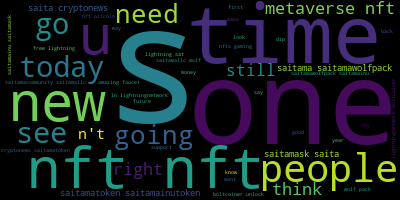

<Figure size 720x720 with 0 Axes>

In [195]:
#Overall wordcloud 
My_WordCloud = WordCloud(background_color="black", max_words=50)

# Join the different tweets titles together.
My_Long_String =','.join(list(df8.values))

# Generate a word cloud & visualize it
plt.figure(figsize=(10,10))
My_WordCloud.generate(My_Long_String)
My_WordCloud.to_image()

In [196]:
positive_polarity = df_enriched[df_enriched['polarity']==1]
negative_polarity = df_enriched[df_enriched['polarity']==-1]
total_text=" ".join(negative_polarity['text'])

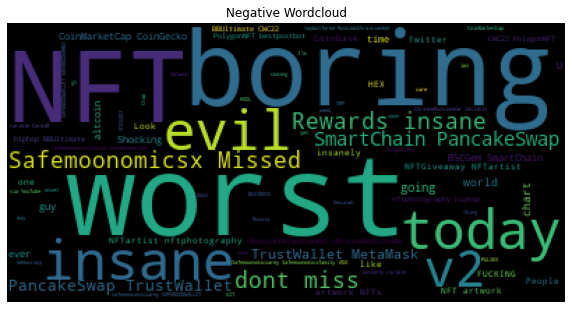

In [197]:
#Generate negative texts wordcloud
negative_wordcloud = WordCloud(stopwords=My_stop_words).generate(total_text)
plt.figure(figsize=(10,10))
plt.title('Negative Wordcloud')
plt.axis('off')
plt.imshow(negative_wordcloud)

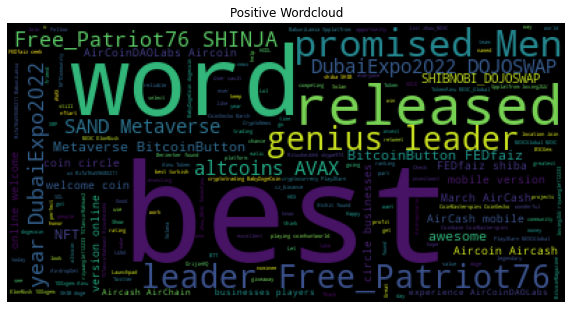

In [198]:
#Generate positive texts wordcloud
total_positive_texts=" ".join(positive_polarity['text'])
positive_wordcloud = WordCloud(stopwords=set(My_stop_words)).generate(total_positive_texts)
plt.figure(figsize=(10,10))
plt.title('Positive Wordcloud')
plt.axis('off')
plt.imshow(positive_wordcloud)

The word cloud shows the frequent word people use in their tweets. ‘Metaverse’ is not related to bitcoin directly while it is still a hot topic about technology firms and future life. If the metaverse is realized, then there is chance that crypto currency could fully replace the money in real life. Similar as ‘NFT’, being labelled as virtual ownership of real word items, could be more popular in the future.Other frequent words including launchpad, and ido is regards to the crypto platform.


### Visualization 2 - Topic_modelling

In [199]:
#Split the dataset based on sentiment score
positive = df_enriched[df_enriched['polarity']==1]
negative = df_enriched[df_enriched['polarity']==-1]

negative['Lematized_text'].replace({r'[^\w\s]+': ''}, regex=True, inplace =True)
negative=negative[['Lematized_text']]
negative0 = negative['Lematized_text'].apply(word_tokenize)
negative_ = negative0.apply(lambda x: [word for word in x if word not in My_stop_words])  

#Topic modelling for negative sentiment data
My_id2word = corpora.Dictionary(negative_)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in negative_]

# Build LDA model
from gensim import models
My_LDA_negative = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=4)
number_of_topics = 4
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))
gensimvis.prepare(My_LDA_negative, My_Corpus, My_id2word)


/Users/sselemahs/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sselemahs/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sselemahs/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sselemahs/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sselemahs/opt/anaconda3/lib/python3.9/site-packages/p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.036247 -0.069653       1        1  26.808463
2      0.111062  0.016397       2        1  26.091723
1     -0.060408  0.077793       3        1  23.592814
3     -0.014407 -0.024537       4        1  23.507000, topic_info=               Term       Freq      Total Category  logprob  loglift
587        lavishly   5.000000   5.000000  Default  30.0000  30.0000
85            worst  11.000000  11.000000  Default  29.0000  29.0000
582      bbultimate   3.000000   3.000000  Default  28.0000  28.0000
583     bestpostbot   3.000000   3.000000  Default  27.0000  27.0000
586          hiphop   3.000000   3.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
85            worst   1.823270  11.003852   Topic4  -5.0042  -0.3497
511        metamask   1.444268   5.759542   Topic4  -5.2372   0.0646
519      smartchain   1.518963   7.567031   Topic4  -5.1868  -0.1579
518  safemoonomicsx   1.325487   5.684755   Topic4  -5.3231  -0.0081
19              nft   1.272530   9.607949   Topic4  -5.3638  -0.5737

[243 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
498       4  0.760360     0004
330       3  0.557999     1000
594       2  0.767678       11
505       1  0.175468       12
505       2  0.350936       12
...     ...       ...      ...
493       4  0.399888      xrp
54        4  0.760222  yelling
27        1  0.827143      yet
4         3  0.405178  youtube
4         4  0.405178  youtube

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [200]:
#Topic modelling for positive sentiment data
positive = df_enriched[df_enriched['Sentiment'] >0.05]
positive['Lematized_text'].replace({r'[^\w\s]+': ''}, regex=True, inplace =True)
positive = positive['Lematized_text'].apply(word_tokenize)
My_stop_words = stopwords.words("English")
My_stop_words = My_stop_words + ['bitcoin','eth','btc','crypto','cryptocurrency','blockchain','project','binance','bnb','bsc','amp','tco','ethereum','market','price','buy','sell','polygon','defi','bullish','cryptocurrencies']
positive_ = positive.apply(lambda x: [word for word in x if word not in My_stop_words])  
My_id2word_positive = corpora.Dictionary(positive_)

# Convert document (a list of words) into the bag-of-words format
My_Corpus_positive = [My_id2word.doc2bow(text) for text in positive_]

# Build LDA model
My_LDA_positive = models.LdaMulticore(corpus=My_Corpus_positive, id2word=My_id2word, num_topics=3)
number_of_topics = 4
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))
gensimvis.prepare(My_LDA_positive, My_Corpus, My_id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.033199  0.055610       1        1  42.568276
2     -0.040731 -0.051957       2        1  30.820150
1      0.073930 -0.003653       3        1  26.611574, topic_info=             Term       Freq      Total Category  logprob  loglift
19            nft  33.000000  33.000000  Default  30.0000  30.0000
96           like  24.000000  24.000000  Default  29.0000  29.0000
461  nftcommunity  13.000000  13.000000  Default  28.0000  28.0000
2          people  10.000000  10.000000  Default  27.0000  27.0000
237       support   9.000000   9.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
281           day   3.039693  11.928030   Topic3  -4.6171  -0.0433
493           xrp   2.629059   8.100122   Topic3  -4.7623   0.1986
112     metaverse   3.067656  17.517695   Topic3  -4.6080  -0.4185
161          year   2.680895  10.796265   Topic3  -4.7427  -0.0692
21             nt   2.759937  19.750403   Topic3  -4.7137  -0.6441

[228 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
290       1  0.230843     1
290       2  0.577107     1
290       3  0.115421     1
331       2  0.849505    50
331       3  0.424752    50
...     ...       ...   ...
161       1  0.370499  year
161       2  0.370499  year
161       3  0.277874  year
27        1  0.315474   yet
27        3  0.630947   yet

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

I used LDA and combine topic modelling with sentiment analysis by setting the sentiment score lower than -0.05 as negative and larger than 0.05 as positive. I removed URL in the text because it shows up in both positive and negative tweets.T he link could be an external website, video, gif or a picture. Most of the discussion in both models is about nft. As expected, ‘negative' adjectives are widely used in negative tweets, such as 'boring','worst'. News has effcts on the tweets as well, like Ukraine War, along with the economic situation like inflation,oil price etc.

### Evaluation

In [201]:
# Compute Coherence Score
cm = CoherenceModel(model=My_LDA_positive, corpus=My_Corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
print (coherence)

cm = CoherenceModel(model=My_LDA_negative, corpus=My_Corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
print (coherence)

#Cross validation - word count
df_len0 =df_len[['RiseFall','word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenghth']]
nominal_len = df_len0[['RiseFall']]
numerical_len = df_len0[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenghth']]

le = preprocessing.LabelEncoder()
nominal_len0 = nominal_len.apply(le.fit_transform)

df_crossed_len = pd.concat([numerical_len, nominal_len0], axis=1)

clf = DecisionTreeClassifier (max_depth = 3)
y = df_len0 ["RiseFall"]
X = df_len0.drop(columns=['RiseFall'])

scores = cross_val_score(clf, X, y, cv=6)
scores.mean()

-21.09574021314971
-15.269313570348961


0.4031272191589575

In [202]:
#Cross validation - polarity
df_enriched_polarity = df_enriched[['polarity','RiseFall']]
nominal_polarity = df_enriched[['RiseFall']]
numerical_polarity = df_enriched[['polarity']]

le = preprocessing.LabelEncoder()
nominal_pola = nominal.apply(le.fit_transform)

df_crossed_len = pd.concat([numerical, nominal], axis=1)

clf = DecisionTreeClassifier (max_depth = 3)
y = df_enriched_polarity ["RiseFall"]
X = df_enriched_polarity.drop(columns=['RiseFall'])

scores = cross_val_score(clf, X, y, cv=6)
scores.mean()

0.40459321286859723

I compute the coherence score and the score from low sentiment and high sentiment is similar, which is -6. I also use the six-fold cross validation to figure out the relationship between bitcoin price and social media. The movement of price has only three options: rise, fall and equal. Therefore, the score must be higher than 33.33%. I choose the word count feature to test the cross-validation score and the result is more than 40% overall. The word count  shows limited information about the price move maybe because of the word limit.